In [2]:
#Import Libraries

#General Libraries
import pandas as pd
import numpy as np
import os

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Prepossing Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from itertools import product
import pickle

#Models
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
#Load Data

#train data
train = pd.read_csv('sales_train.csv')

#supplement data
items           = pd.read_csv('items.csv') #item id and its category id
item_categories = pd.read_csv('item_categories.csv') #item category name
shops           = pd.read_csv('shops.csv') #shop name
test            = pd.read_csv('test.csv') #test data

FileNotFoundError: [Errno 2] No such file or directory: 'sales_train.csv'

**2) Explore Data**

In [4]:
#Transaction Data
print("Shape of train: "+ str(train.shape))
train.head()

Shape of train: (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
print("Maximum of date_block_num:",train.date_block_num.max())

Maximum of date_block_num: 33


**Item Price Investigation**

In [7]:
train.item_price.value_counts()
print("Number of prices:",train.item_price.nunique())
print("Maximum of prices:",train.item_price.max())
print("Data with maximum price:")
train[train.item_price==train.item_price.max()]

Number of prices: 19993
Maximum of prices: 307980.0
Data with maximum price:


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [8]:
max_id = train[train.item_price==train.item_price.max()].item_id.values[0]
items[items.item_id==max_id]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [9]:
train[train.item_id==max_id]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [10]:
min_id = train[train.item_price==train.item_price.min()].item_id.values[0]
items[items.item_id==min_id]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


In [11]:
train[train.item_id==min_id]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.00,13.0
353,16.01.2013,0,25,2973,2499.00,5.0
354,17.01.2013,0,25,2973,2499.00,3.0
355,18.01.2013,0,25,2973,2499.00,2.0
356,19.01.2013,0,25,2973,2499.00,3.0
...,...,...,...,...,...,...
1765321,22.06.2014,17,57,2973,1249.50,1.0
1782298,09.06.2014,17,47,2973,1249.00,1.0
1851765,04.07.2014,18,26,2973,1249.50,1.0
1923837,06.08.2014,19,6,2973,1249.50,1.0


<AxesSubplot: >

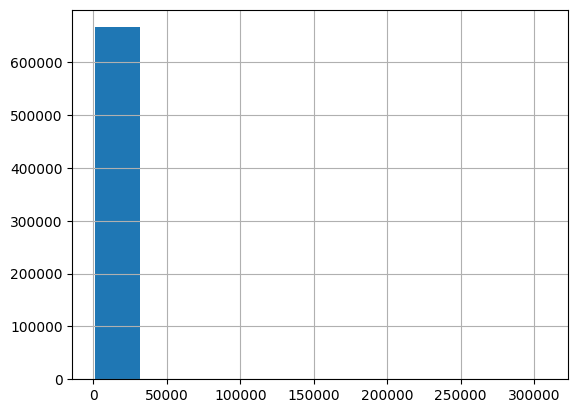

In [12]:
train[train.item_price>=1000].item_price.hist()

**Item Category**

In [13]:
#Translate the item category name and create meta category, subtype
symbols=(u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ", u"abvgdeejzijklmnoprstufhzcss_y_euaABVGDEEJZIJKLMNOPRSTUFHZCSS_Y_EUA")
english = {ord(a):ord(b) for a, b in zip(*symbols)}

item_categories['items_english'] = item_categories['item_category_name'].apply(lambda x: x.translate(english))
item_categories['meta_category'] = item_categories['items_english'].apply(lambda x: x.split('-')[0])
item_categories['subtype'] = item_categories['items_english'].apply(lambda x: x.split('-')) \
                                                             .map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_categories.head(80)

,Unnamed: 0,item_category_name,item_category_id,items_english,meta_category,subtype
0,0,PC - Headset / Headphones,0,PC - Headset / Headphones,PC,Headset / Headphones
1,1,Accessories - PS2.,1,Accessories - PS2.,Accessories,PS2.
2,2,Accessories - PS3,2,Accessories - PS3,Accessories,PS3
3,3,Accessories - PS4.,3,Accessories - PS4.,Accessories,PS4.
4,4,Accessories - PSP.,4,Accessories - PSP.,Accessories,PSP.
...,...,...,...,...,...,...
75,75,Programs - for home and office,75,Programs - for home and office,Programs,for home and office
76,76,Programs - for home and office (digit),76,Programs - for home and office (digit),Programs,for home and office (digit)
77,77,Programs - Educational,77,Programs - Educational,Programs,Educational
78,78,Programs - training (digit),78,Programs - training (digit),Programs,training (digit)


In [14]:
i_c = item_categories

i_c.to_csv('Cat.csv', index=False)

In [15]:
print(item_categories.meta_category.value_counts())

Books                                   13
Gifts                                   12
Games                                    8
Gaming Consoles                          7
Accessories                              7
Programs                                 6
Music                                    6
Cinema                                   4
Payment cards                            3
PC Games                                 3
Clean media (piece)                      1
Clean media (spire)                      1
Service                                  1
Service                                  1
PC                                       1
Movie                                    1
Payment maps                             1
Payment cards (cinema, music, games)     1
PC games                                 1
MAC games                                1
Android games                            1
Gaming consoles                          1
Delivery of goods                        1
Tickets (di

In [16]:
#Label Encoding
labelencoder = LabelEncoder()
item_categories["meta_category_code"] = labelencoder.fit_transform(item_categories["meta_category"])
item_categories["subtype_code"] = labelencoder.fit_transform(item_categories["subtype"])
item_categories = item_categories.drop(["items_english", "meta_category", "subtype"], axis=1)

In [17]:
#Let's see what it looks like now

item_categories.head(5)

,Unnamed: 0,item_category_name,item_category_id,meta_category_code,subtype_code
0,0,PC - Headset / Headphones,0,14,25
1,1,Accessories - PS2.,1,0,34
2,2,Accessories - PS3,2,0,35
3,3,Accessories - PS4.,3,0,37
4,4,Accessories - PSP.,4,0,40


In [18]:
#Translate the shop name and identify towns
shops["shops_english"] = shops["shop_name"].apply(lambda x: x.translate(english))
shops["town"] = shops["shops_english"].apply(lambda x: x.split()[0])
shops.head(5)

,Unnamed: 0,shop_name,shop_id,shops_english,town
0,0,"! Yakutsk Ordzhonikidze, 56 fran",0,"! Yakutsk Ordzhonikidze, 56 fran",!
1,1,"! Yakutsk shopping center ""Central"" Fran",1,"! Yakutsk shopping center ""Central"" Fran",!
2,2,"Adygea shopping center ""Mega""",2,"Adygea shopping center ""Mega""",Adygea
3,3,"Balashiha TRK ""October-Kinomir""",3,"Balashiha TRK ""October-Kinomir""",Balashiha
4,4,"Volzhsky shopping center ""Volga Mall""",4,"Volzhsky shopping center ""Volga Mall""",Volzhsky


In [19]:
#Clean Up Data - Label encoding

shops = shops.drop(["shops_english", "town"], axis=1)

In [20]:
#Let's see if it did what it was suppose to
shops.head(5)

,Unnamed: 0,shop_name,shop_id
0,0,"! Yakutsk Ordzhonikidze, 56 fran",0
1,1,"! Yakutsk shopping center ""Central"" Fran",1
2,2,"Adygea shopping center ""Mega""",2
3,3,"Balashiha TRK ""October-Kinomir""",3
4,4,"Volzhsky shopping center ""Volga Mall""",4


Transactions

In [21]:
# Remove dates
newcols = train["date"].str.split(".", expand=True)
ls = ["day", "month", "year"]
for i in range(len(ls)):
    train.insert(i, ls[i], newcols[i])
train['weekday'] = pd.to_datetime(train['date'], format = '%d.%m.%Y').dt.dayofweek
train.pop("date")

# Add item category for each item
train['item_category_id'] = [items['item_category_id'].values[i] for i in train['item_id'].values]

# Add revenues
train["revenue"] = train["item_price"]*train["item_cnt_day"]

In [22]:
#Let's confirm it worked
train.head(5)

,day,month,year,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,item_category_id,revenue
0,02,01,2013,0,59,22154,999.00,1.0,2,37,999.00
1,03,01,2013,0,25,2552,899.00,1.0,3,58,899.00
2,05,01,2013,0,25,2552,899.00,-1.0,5,58,-899.00
3,06,01,2013,0,25,2554,1709.05,1.0,6,58,1709.05
4,15,01,2013,0,25,2555,1099.00,1.0,1,56,1099.00


In [23]:
train.to_csv('Sales.csv', index=False)

<AxesSubplot: >

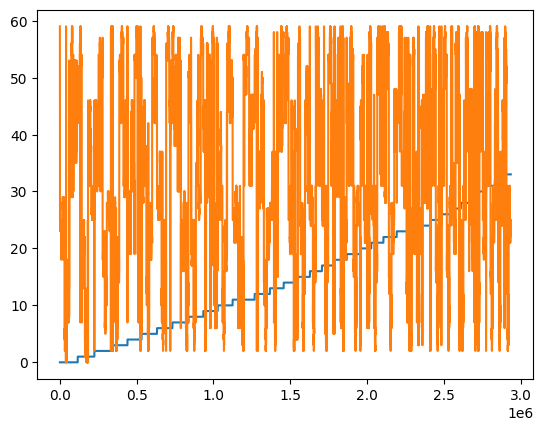

In [24]:
train.date_block_num.plot()
train.shop_id.plot()

In [25]:
train=train.merge(items, how='left')
train=train.merge(item_categories, how='left')
train=train.merge(shops, how='left')

In [26]:
train.head()
full=train
full.to_csv('full.csv', index=False)

In [27]:
#Remove columns
train.drop("item_name",axis=1,inplace=True)
train.drop("shop_name",axis=1,inplace=True)
train.drop("item_category_name",axis=1,inplace=True)


#Confirm it worked
train.head()

,day,month,year,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,item_category_id,revenue,Unnamed: 0,meta_category_code,subtype_code
0,02,01,2013,0,59,22154,999.00,1.0,2,37,999.00,37,12,7
1,03,01,2013,0,25,2552,899.00,1.0,3,58,899.00,58,13,53
2,05,01,2013,0,25,2552,899.00,-1.0,5,58,-899.00,58,13,53
3,06,01,2013,0,25,2554,1709.05,1.0,6,58,1709.05,58,13,53
4,15,01,2013,0,25,2555,1099.00,1.0,1,56,1099.00,56,13,60


**Analysis**

Revenue

<AxesSubplot: xlabel='date_block_num'>

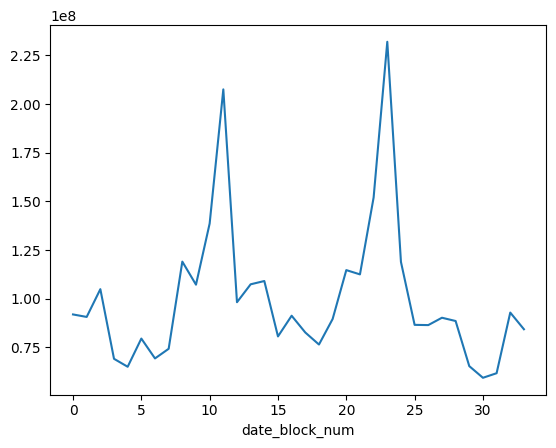

In [28]:
#Revenue seems to increase during Christmas time period and decrease during summer
train.groupby("date_block_num")["revenue"].sum().plot()

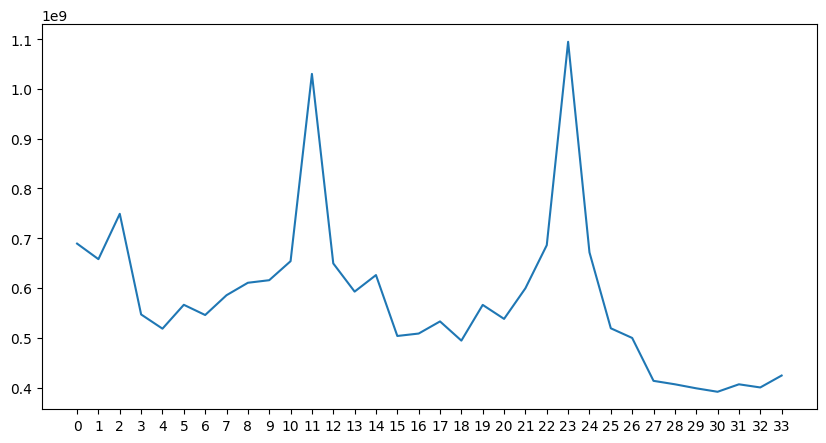

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by date_block_num and calculate the sum of revenue
revenue_by_month = train.groupby("date_block_num")["revenue"].sum()

plt.figure(figsize=(10, 5))

# Create a line plot of the total revenue per month
plt.plot(revenue_by_month)

# Set the x-ticks to show each value of the date_block_num column
plt.xticks(range(len(revenue_by_month.index)), revenue_by_month.index)

# Show the plot
plt.show()


<AxesSubplot: xlabel='weekday'>

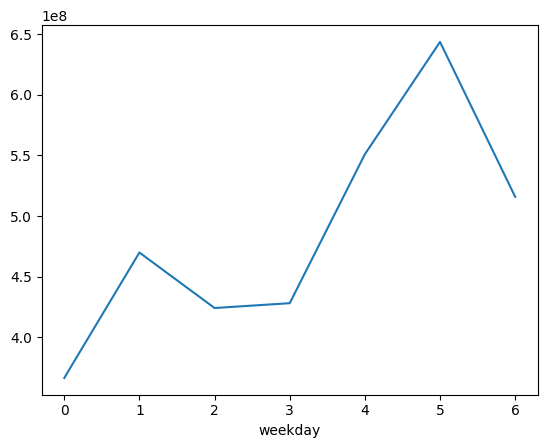

In [29]:
#Week Day vs Weekend
train.groupby("weekday")["revenue"].sum().plot()

<AxesSubplot: xlabel='shop_id'>

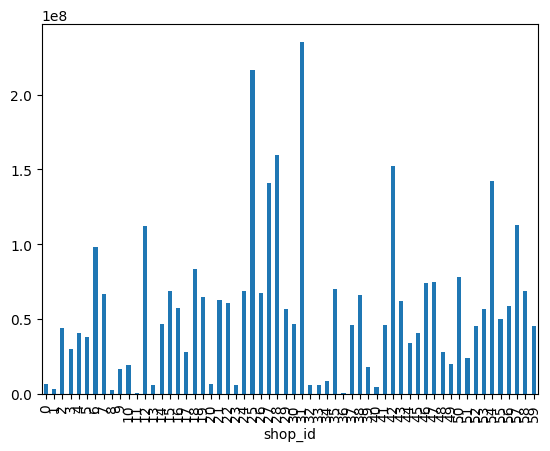

In [30]:
train.groupby("shop_id")["revenue"].sum().plot.bar()
#Not super helpful but there does seem to be some spikes

<AxesSubplot: >

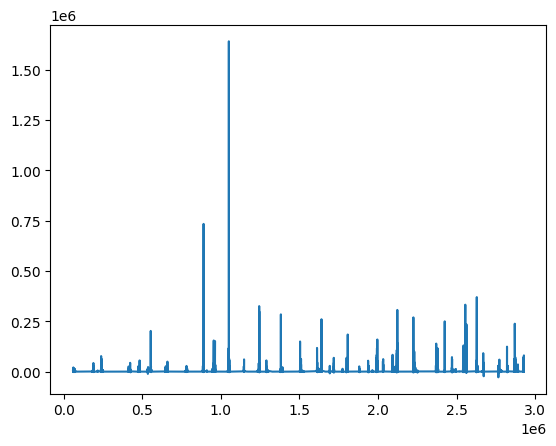

In [31]:
#Look into Spike
train[train["shop_id"]==31]["revenue"].plot()

<AxesSubplot: xlabel='date_block_num'>

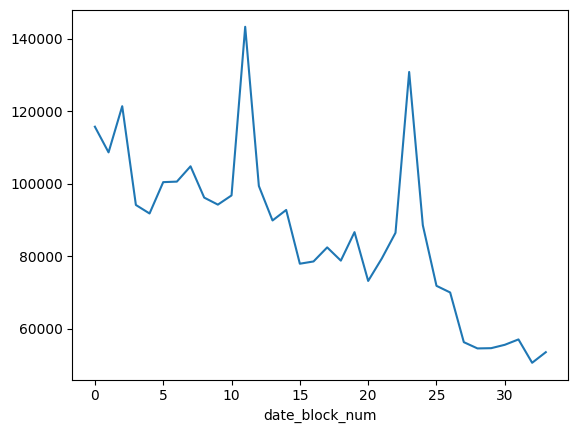

In [32]:
#Revenue is increasing because the price has gone up not because sales have
train.groupby("date_block_num").count().revenue.plot()

<AxesSubplot: xlabel='date_block_num'>

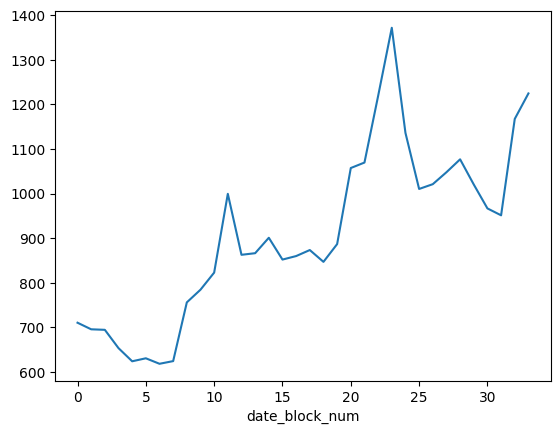

In [33]:
train.groupby("date_block_num").item_price.mean().plot()

<AxesSubplot: xlabel='date_block_num'>

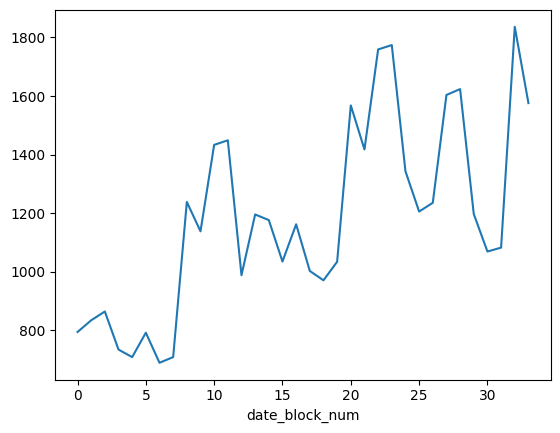

In [34]:
train.groupby("date_block_num").revenue.mean().plot()

C:\Users\97798\AppData\Local\Temp\ipykernel_17300\3271430928.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train.groupby(["date_block_num","item_category_id"]).sum()["revenue"].unstack().plot(figsize=(20,20))


Text(0.5, 1.0, 'Item Category Revenue')

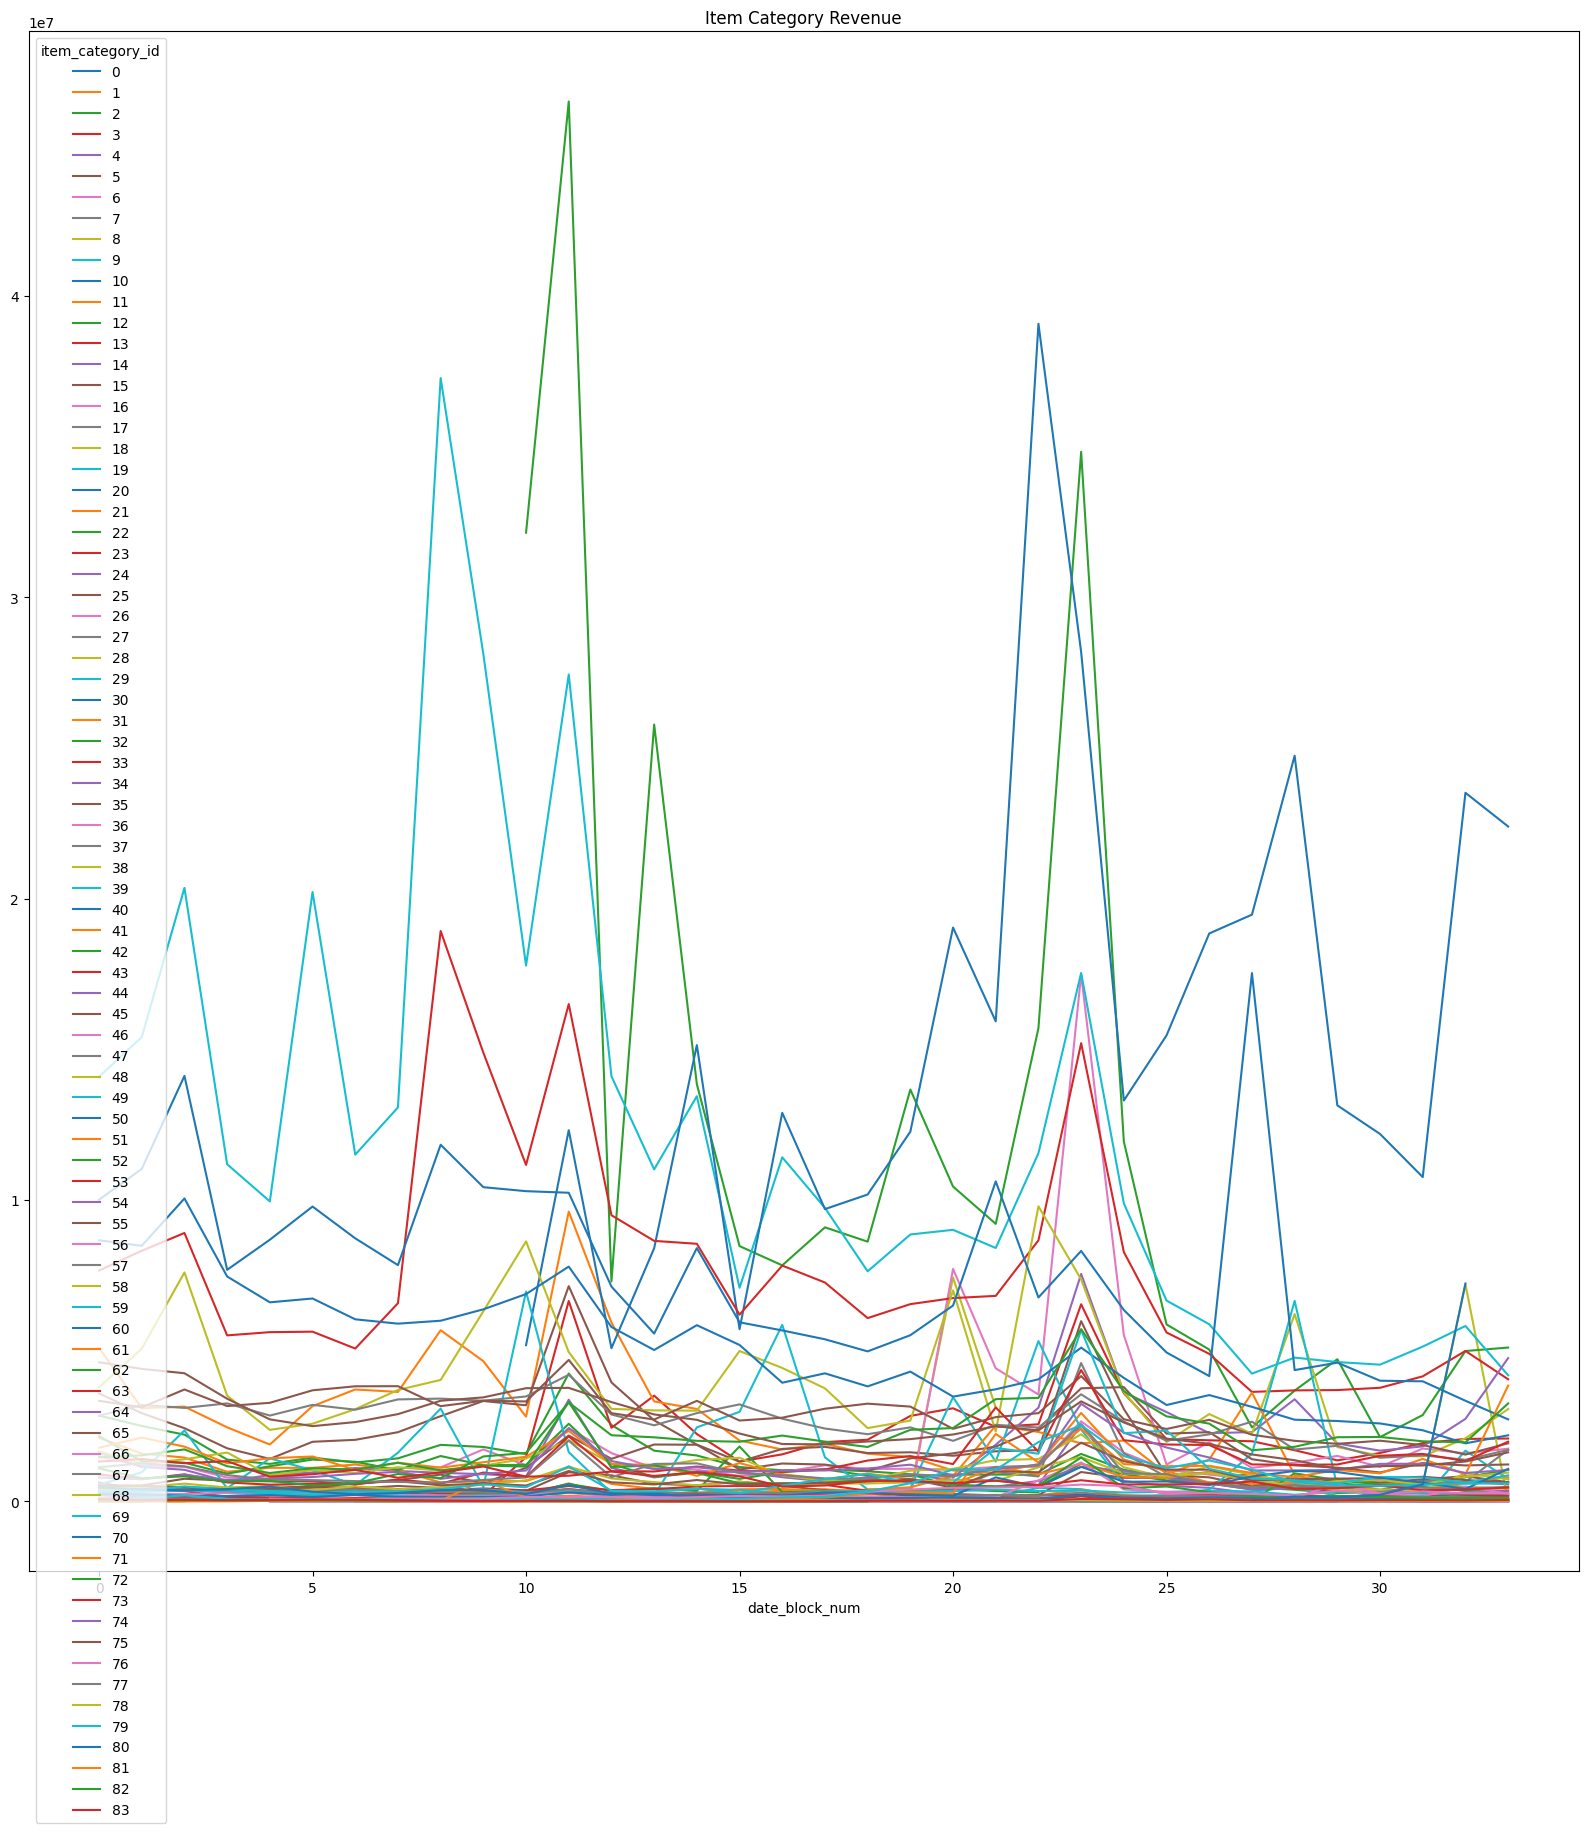

In [35]:
#Plot
train.groupby(["date_block_num","item_category_id"]).sum()["revenue"].unstack().plot(figsize=(20,20))
plt.title('Item Category Revenue')

Revenue Summary
* Revenue seems to peak around the Christmas holiday time period and slow down during the summer
* Revenue seems to be higher on the weekend then during the week
* Some shops/locations perform better than others (in some cases significantly)
* Revenue is increasing even though transactions are falling most likely due to increase in price

**Shop**

In [36]:
#It seems that shop 10 and 11 are the same, shop 1 and 58 are the same, shop 0 and 57 are the same
train.loc[train["shop_id"]==11,"shop_id"]=10
train.loc[train["shop_id"]==1,"shop_id"]=58
train.loc[train["shop_id"]==0,"shop_id"]=57

In [37]:
#Check whether all the shops are both in train and test sets
test_list = list(sorted(test["shop_id"].unique()))
out_of_list = [i for i in list(range(60)) if i not in test_list]
print(out_of_list)

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]


In [38]:
# 9 and 20 only have limited transactions
train[(train["shop_id"]==9) | (train["shop_id"]==20)].groupby(["shop_id","date_block_num"]).sum()["revenue"]

C:\Users\97798\AppData\Local\Temp\ipykernel_17300\3635285027.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train[(train["shop_id"]==9) | (train["shop_id"]==20)].groupby(["shop_id","date_block_num"]).sum()["revenue"]


shop_id  date_block_num
9        9                 5844108.0
         21                6615741.0
         27                  -3190.0
         33                3916178.0
20       21                3498559.0
         33                3101365.0
Name: revenue, dtype: float64

**3) Prepossing and Final Prepping of Data**

In [39]:
#Remove outliers (You can't always do this in the real world)
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [40]:
train.head()

,day,month,year,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,item_category_id,revenue,Unnamed: 0,meta_category_code,subtype_code
0,02,01,2013,0,59,22154,999.00,1.0,2,37,999.00,37,12,7
1,03,01,2013,0,25,2552,899.00,1.0,3,58,899.00,58,13,53
2,05,01,2013,0,25,2552,899.00,-1.0,5,58,-899.00,58,13,53
3,06,01,2013,0,25,2554,1709.05,1.0,6,58,1709.05,58,13,53
4,15,01,2013,0,25,2555,1099.00,1.0,1,56,1099.00,56,13,60


In [41]:
train.drop("Unnamed: 0",axis=1,inplace=True)


In [42]:
train.drop("item_cnt_day",axis=1,inplace=True)
train.head()

,day,month,year,date_block_num,shop_id,item_id,item_price,weekday,item_category_id,revenue,meta_category_code,subtype_code
0,02,01,2013,0,59,22154,999.00,2,37,999.00,12,7
1,03,01,2013,0,25,2552,899.00,3,58,899.00,13,53
2,05,01,2013,0,25,2552,899.00,5,58,-899.00,13,53
3,06,01,2013,0,25,2554,1709.05,6,58,1709.05,13,53
4,15,01,2013,0,25,2555,1099.00,1,56,1099.00,13,60


In [43]:
train.drop("item_category_id",axis=1,inplace=True)
train.head()

,day,month,year,date_block_num,shop_id,item_id,item_price,weekday,revenue,meta_category_code,subtype_code
0,02,01,2013,0,59,22154,999.00,2,999.00,12,7
1,03,01,2013,0,25,2552,899.00,3,899.00,13,53
2,05,01,2013,0,25,2552,899.00,5,-899.00,13,53
3,06,01,2013,0,25,2554,1709.05,6,1709.05,13,53
4,15,01,2013,0,25,2555,1099.00,1,1099.00,13,60


In [44]:
train.isnull().sum()

day                   0
month                 0
year                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
weekday               0
revenue               0
meta_category_code    0
subtype_code          0
dtype: int64

In [45]:
encoder = LabelEncoder()

In [46]:
train['day']= encoder.fit_transform(train['day'])
train['month']= encoder.fit_transform(train['month'])
train['year']= encoder.fit_transform(train['year'])
train['date_block_num']= encoder.fit_transform(train['date_block_num'])
train['shop_id']= encoder.fit_transform(train['shop_id'])
train['item_id']= encoder.fit_transform(train['item_id'])
train['item_price']= encoder.fit_transform(train['item_price'])
train['weekday']= encoder.fit_transform(train['weekday'])
train['revenue']= encoder.fit_transform(train['revenue'])
train['meta_category_code']= encoder.fit_transform(train['meta_category_code'])
train['subtype_code']= encoder.fit_transform(train['subtype_code'])

In [51]:
train.to_csv('feature_withOP.csv', index=False)

In [47]:
#Split Train/Test

X_train = train[train.date_block_num < 30].drop(['revenue'], axis=1)
y_train = train[train.date_block_num < 30]['revenue']
X_val = train[train.date_block_num == 30].drop(['revenue'], axis=1)
y_val = train[train.date_block_num == 30]['revenue']
X_test = train[train.date_block_num > 30].drop(['revenue'], axis=1)
X_test_wr = train[train.date_block_num > 30]

In [49]:
# For saving data & output results / models
def post_processing(model,model_name,X_train,X_val,X_test,y_train,y_val,test):
    # Here we once again clip the output to 0~20+
    train_pred = model.predict(X_train).clip(0, 20)
    val_pred = model.predict(X_val).clip(0, 20)
    test_pred = model.predict(X_test).clip(0, 20)

In [53]:

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

c:\Users\97798\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\97798\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5731.41316	validation_1-rmse:5889.93967
[1]	validation_0-rmse:4129.00227	validation_1-rmse:4138.62556
[2]	validation_0-rmse:3049.41104	validation_1-rmse:2950.06385
[3]	validation_0-rmse:2343.12269	validation_1-rmse:2159.43115
[4]	validation_0-rmse:1901.41843	validation_1-rmse:1649.82981
[5]	validation_0-rmse:1640.21476	validation_1-rmse:1343.10052
[6]	validation_0-rmse:1505.42733	validation_1-rmse:1185.18944
[7]	validation_0-rmse:1418.53757	validation_1-rmse:1095.60531
[8]	validation_0-rmse:1372.16944	validation_1-rmse:1057.06203
[9]	validation_0-rmse:1345.78591	validation_1-rmse:1040.66106
[10]	validation_0-rmse:1331.75121	validation_1-rmse:1034.16759
[11]	validation_0-rmse:1324.25438	validation_1-rmse:1031.78927
[12]	validation_0-rmse:1316.11068	validation_1-rmse:1031.67158
[13]	validation_0-rmse:1312.71444	validation_1-rmse:1031.96965
[14]	validation_0-rmse:1309.16056	validation_1-rmse:1032.50824
[15]	validation_0-rmse:1306.43918	validation_1-rmse:1032.28452
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=300, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

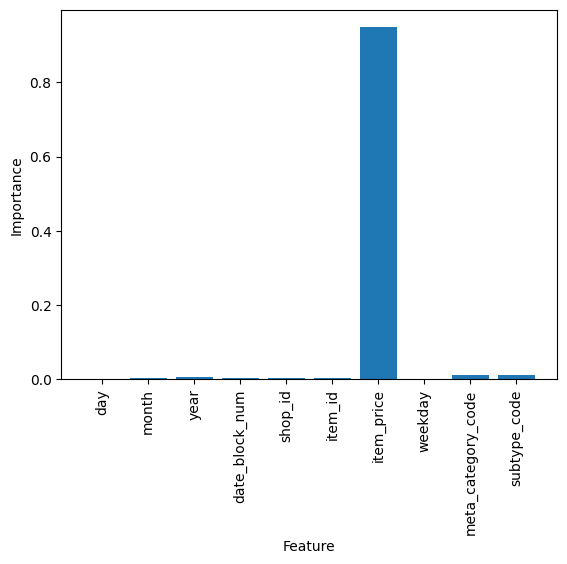

In [54]:
# Plot the feature importances
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

In [56]:
training_data_prediction = model.predict(X_train)
r2_train = metrics.r2_score(y_train, training_data_prediction)
print('R Squared value = ', r2_train)
testing_data_prediction = model.predict(X_val)
r2_test = metrics.r2_score(y_val, testing_data_prediction)
print('R Squared value = ', r2_test)


R Squared value =  0.9217370788415223
R Squared value =  0.949993323020383


In [61]:
import numpy as np

mse = mean_squared_error(y_train, training_data_prediction)
rmse = np.sqrt(mse)
print("MSE = ",mse)
print("RMSE = ",rmse)


MSE =  1637218.7129163179
RMSE =  1279.5384765282824


In [ ]:
#save model
model.save_model('model.json')

In [ ]:
X_test_wr

,day,month,year,date_block_num,shop_id,item_id,item_price,weekday,revenue,meta_category_code,subtype_code
2774718,30,7,2,31,39,4177,3819,0,3727,15,50
2774719,9,7,2,31,43,12532,6489,0,5613,12,7
2774720,8,7,2,31,43,13304,16444,6,14291,10,57
2774721,21,7,2,31,43,12584,1756,5,2163,3,18
2774722,7,7,2,31,43,12607,809,5,1430,3,18
...,...,...,...,...,...,...,...,...,...,...,...
2935844,9,9,2,33,22,7262,3819,5,3727,13,28
2935845,8,9,2,33,22,7313,3819,4,3727,13,28
2935846,13,9,2,33,22,7312,4496,2,4200,13,28
2935847,21,9,2,33,22,7293,3819,3,3727,13,66


<AxesSubplot: xlabel='day'>

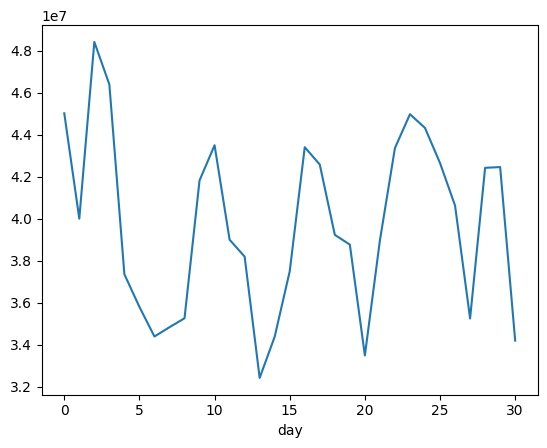

In [ ]:
X_test_wr.groupby("day")["revenue"].sum().plot()

In [ ]:
X_test_1=X_test

In [ ]:
X_test_1['pred_revenue'] = model.predict(X_test_1)

In [ ]:
X_test_1.head(20)

,day,month,year,date_block_num,shop_id,item_id,item_price,weekday,meta_category_code,subtype_code,pred_revenue
2774718,30,7,2,31,39,4177,3819,0,15,50,4048.877686
2774719,9,7,2,31,43,12532,6489,0,12,7,5571.864258
2774720,8,7,2,31,43,13304,16444,6,10,57,14310.732422
2774721,21,7,2,31,43,12584,1756,5,3,18,2162.986084
2774722,7,7,2,31,43,12607,809,5,3,18,1404.084473
2774723,18,7,2,31,43,12607,809,2,3,18,1388.072266
2774724,23,7,2,31,43,12609,2266,0,3,7,2590.004639
2774725,20,7,2,31,43,13340,16034,4,10,57,13820.558594
2774726,14,7,2,31,43,12668,2709,5,13,28,2829.199707
2774727,30,7,2,31,43,12677,5277,0,3,18,4959.975098


<AxesSubplot: xlabel='day'>

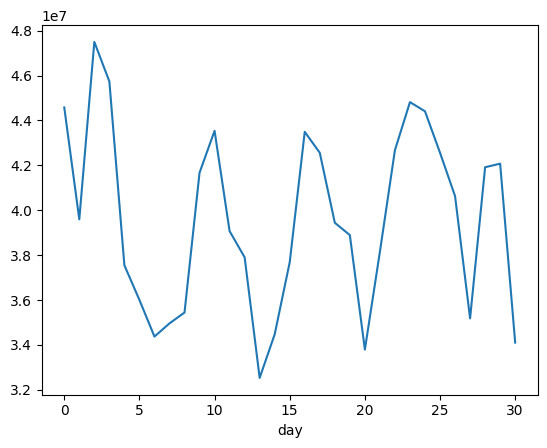

In [ ]:
X_test_1.groupby("day")["pred_revenue"].sum().plot()

In [1]:
X = X_test_1['day']
Y1 = X_test_wr.groupby("day")["revenue"].sum()
Y2 = X_test_1.groupby("day")["pred_revenue"].sum()
size=[]

plt.scatter(X,Y1,color='k')
plt.scatter(X,Y2,color='g')
plt.show()

NameError: name 'X_test_1' is not defined

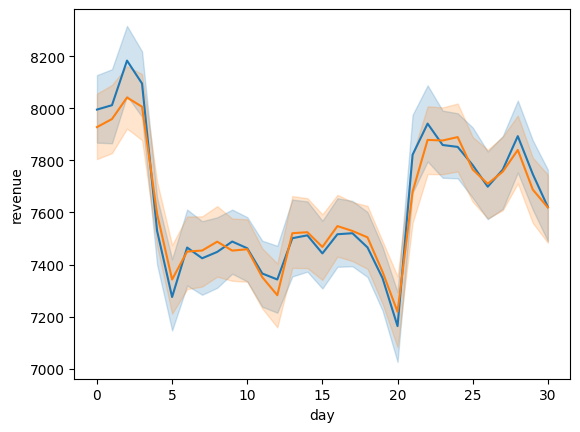

In [ ]:
sns.lineplot(x=X_test_1['day'], y=X_test_wr["revenue"], ax=plt.gca())
sns.lineplot(x=X_test_1['day'], y=X_test_1["pred_revenue"], ax=plt.gca())
plt.show()

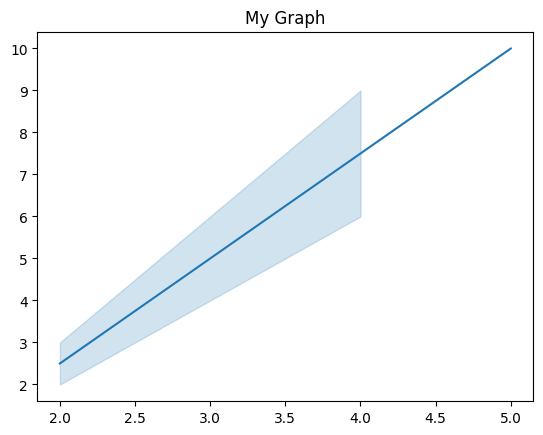

In [ ]:

x1 = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]
x2 = [2, 2, 4, 4, 5]
y2 = [2, 3, 6, 9, 10]
# create the first line plot


# create the second line plot and add it to the first plot
# sns.lineplot(x=x1, y=y1)
sns.lineplot(x=x2, y=y2)
# add a title for the graph
plt.title('My Graph')

# display the graph
plt.show()


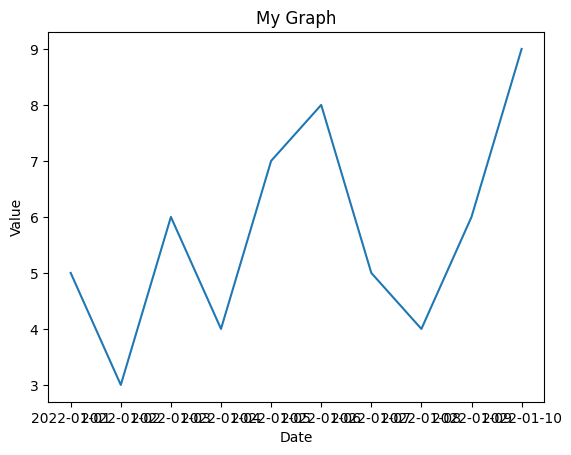

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# create a list of dates
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 1, 10)
delta = timedelta(days=1)
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta

# create a list of values
values = [5, 3, 6, 4, 7, 8, 5, 4, 6, 9]

# create a line plot with dates and values
plt.plot(dates, values)

# set the x-axis format to show dates and intervals of days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# add labels for x and y axis
plt.xlabel('Date')
plt.ylabel('Value')

# add a title for the graph
plt.title('My Graph')

# display the graph
plt.show()


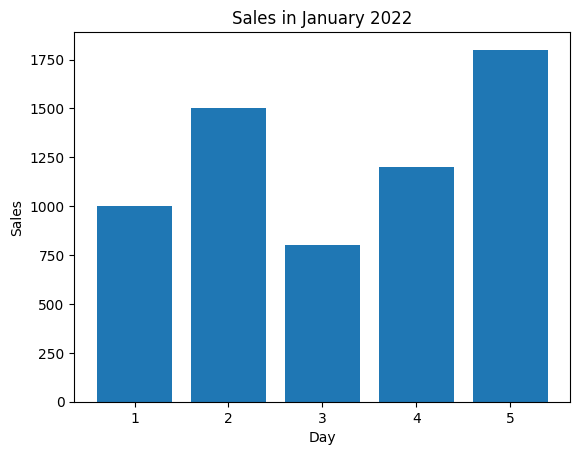

In [ ]:
import matplotlib.pyplot as plt

# example sales data
sales_data = [
    {"day": 1, "month": "January", "year": 2022, "sales": 1000},
    {"day": 2, "month": "January", "year": 2022, "sales": 1500},
    {"day": 3, "month": "January", "year": 2022, "sales": 800},
    {"day": 4, "month": "January", "year": 2022, "sales": 1200},
    {"day": 5, "month": "January", "year": 2022, "sales": 1800},
    # ... and so on for the rest of the month
]

# extract data for a specific month and year
target_month = "January"
target_year = 2022
month_sales_data = [d for d in sales_data if d["month"] == target_month and d["year"] == target_year]

# create lists of days and sales for the month
days = [d["day"] for d in month_sales_data]
sales = [d["sales"] for d in month_sales_data]

# create the bar graph
plt.bar(days, sales)
plt.title(f"Sales in {target_month} {target_year}")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset into a Pandas dataframe
df = pd.read_csv('sales_data.csv')

# Extract the daily sales for a specific month
month_sales = df.loc[df['month'] == 'January', 'sales']

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the daily sales data on the graph
ax.plot(month_sales)

# Set the title and axis labels
ax.set_title('Daily Sales for January')
ax.set_xlabel('Day')
ax.set_ylabel('Sales')

# Display the graph
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'sales_data.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from a CSV file
sales_data = pd.read_csv('sales_data.csv')

# Convert the 'Date' column to a datetime object
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Filter the dataset to include only the data for a specific month
month_sales = sales_data.loc[(sales_data['Date'].dt.month == 3)]

# Group the data by day and sum the sales for each day
daily_sales = month_sales.groupby(sales_data['Date'].dt.day)['Sales'].sum()

# Create a line graph of the daily sales
plt.plot(daily_sales.index, daily_sales.values)
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Daily Sales in March')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'sales_data.csv'